In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.mlab as mlab
from Optimizers.Vprop4 import Vprop as Vprop
from Optimizers.noisyAdam import noisyAdam as noisyAdam
from Optimizers.noisyKFAC3 import noisyKFAC as noisyKFAC
from Optimizers.Newton import Newton as Newton
from Utilities.create_dataloaders import create_dataloaders 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader

# Linear Regression Energy Landscape on 2 Parameters (w1*, w2*)

####  <span style="color:blue">NORMAL SETUP</span> 
####  $y = Xw + \epsilon$
#### Let **$X$** be an $n$x$k$ matrix with $n$ observations and $k$ features. 
#### Let $y$ be an $n$x$1$ vector 
#### Let $\epsilon$ be an $n$x$1$ vector
#### Let $w$ be an $k$x$1$ vector

### Experiment 1:
#### In this experiment we would like to test how well the optimizers capture the distribution of our weights when most of the variability introduced to the model stems from the weights. That is, we eliminate variablity stemming from the data ($X$) by choosing only one sample, and we generate our targets ($y$) by sampling $n$ weight pairs from a distribution of choice. 

####  <span style="color:blue">EXP1 SETUP</span> 
####  $y = Xw + \epsilon$
#### Let **$X$** be an   <span style="color:blue">$1$x$k$</span>  matrix with <span style="color:blue">$1$</span> observation and $k$ features. 
#### Let $y$ be an <span style="color:blue">$1$x$n$</span> vector 
#### Let $\epsilon$ be an <span style="color:blue">$1$x$n$</span> vector
#### Let $w$ be an <span style="color:blue">$k$x$n$</span>  vector

### Let's Start!
#### 1. Define the Weight Distribution

In [2]:
# [ ] TO DO: ADD HIERARCHICAL STRUCTURE TO WEIGHTS
# [x]      : IMPLEMENT (or quasi) NEWTON METHOD (to see 2nd order behavior)

w_mu  = np.array( [2 , 1] )                       # <======== Define W mu
w_S   = np.matrix(' 1 0 ; 0 1 ')                  # <======== Define W Sigma
n     = 1000                                      # <======== Define number of weights to be drawn


w = np.random.multivariate_normal( w_mu, w_S, n).astype(np.float32)
w = np.around(w, 1).transpose()          # we round to 1 decimal for easy meshgrid plot computation
print('w shape (kxn): ', w.shape)

w shape (kxn):  (2, 1000)


#### 2. Define $X$ data sample

In [3]:
X = np.array( [[2. , 3.]], dtype=np.float32)
print('X shape (1xk):    ', X.shape)


# __________ NOTE ____________ 
# We create Xrep n-by-k matrix
# to get y_hat vector later in
# training. Otherwise, with a 
# 1-by-2 X design-matrix we can
# not get y_hat vectors during
# optimization.

Xrep = np.repeat(X, n, axis=0).reshape(n,2)
print('Xrep shape (nxk): ', Xrep.shape)

X shape (1xk):     (1, 2)
Xrep shape (nxk):  (1000, 2)


#### 3. Define Noise $(\epsilon)$ Sigma

In [4]:
e_sigma = 0.5                          # <======== Define Noise Sigma
eps = np.random.normal(0, e_sigma, n).reshape(1,n).astype(dtype=np.float32)
print('Noise shape (1xn): ', eps.shape)

Noise shape (1xn):  (1, 1000)


#### 4. Create $y$ (with some noise)

In [5]:
Y = np.add( np.matmul( X, w), eps)
print('y shape (1xn): ', Y.shape)

y shape (1xn):  (1, 1000)


#### 5. Define Linear Regression Network

In [6]:
class LinearRegressionModel(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(LinearRegressionModel, self).__init__()
        self.Linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, x):
        return self.Linear(x)

#### 6. Define Initialization Point 

In [7]:
input_dim  = 2
output_dim = 1

SGD_model       = LinearRegressionModel(input_dim,output_dim)
LBFGS_model     = LinearRegressionModel(input_dim,output_dim)
Newton_model    = LinearRegressionModel(input_dim,output_dim)
Vprop_model     = LinearRegressionModel(input_dim,output_dim)
noisyAdam_model = LinearRegressionModel(input_dim,output_dim)
noisyKFAC_model = LinearRegressionModel(input_dim,output_dim)


criterion = nn.MSELoss()# Mean Squared Loss


# W Initialization Point
i0 = torch.Tensor([-7.5 , -2])               # <========= Define Init Point
i0.resize_(1,2)
for p in list(SGD_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(Newton_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(LBFGS_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(Vprop_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(noisyAdam_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(noisyKFAC_model.parameters()):
    p.data = torch.Tensor(i0)


#### 7. Tune Optimizers

In [8]:
# Define hyperparameters
l_rate    = 1e-2
precision = 1
alpha     = 0.99999
N         = n/100
gamma_ex  = 1
t_inv     = 1
t_stats   = 1

# optimizers
SGD   = torch.optim.SGD(SGD_model.parameters(), lr=l_rate)

NEWTON= Newton(Newton_model.parameters(), lr=1)

LBFGS = torch.optim.LBFGS(LBFGS_model.parameters(), lr=l_rate)

VPROP = Vprop(Vprop_model.parameters(), alpha=alpha, precision=precision, lr=l_rate)

nADAM = noisyAdam(noisyAdam_model.parameters(), num_examples=N, gamma_ex=gamma_ex, lr=l_rate)

nKFAC = noisyKFAC(params=noisyKFAC_model.parameters(), layers=noisyKFAC_model.modules(), num_examples=N, lr=l_rate, t_inv=t_inv, t_stats=t_stats)


#### 8. Energy Landscape Function

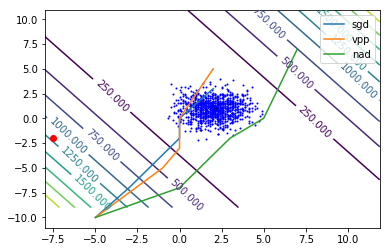

In [9]:
# An example for experimentation
ws = 10                                      # <============= define window scale factor
W1 = np.arange(w_mu[0]-ws, w_mu[0]+ws, 0.1)
W2 = np.arange(w_mu[1]-ws, w_mu[1]+ws, 0.1)
W1, W2 = np.meshgrid(W1, W2)

#eps = np.random.normal(0, 5, 2*n).reshape(n,2)
Z = np.zeros(shape=(len(W1), len(W1)))
for i in range(len(W1)):
    for j in range(len(W1)):
        Xw = np.matmul(Xrep, np.row_stack((W1[0,i], W2[j,0])).astype(np.float32))
        #Xw = np.matmul(X, np.row_stack((W1[0,i], W2[j,0])).astype(np.float32))
        Z[i,j] = np.mean((Y.transpose() - Xw)**2)


        
plt.figure()
CS = plt.contour(W1, W2, Z, 10)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(w_mu[0], w_mu[1], 'ko')
plt.plot(w[0],w[1], 'bo', markersize=1)
plt.plot(i0[0][0], i0[0][1], 'ro')
plt.plot([-5,-3,0,0,2], [-10,-7,-2,0,3], label='sgd')
plt.plot([-5,-1,0,0,2], [-10,-5,-3,0,5], label='vpp')
plt.plot([-5,0,3,5,7], [-10,-7,-2,0,7], label='nad')
plt.legend(loc='upper right')
plt.show()




# Function used during training based on above example
def plot_landscape_and_losses(vpp_dist, nad_dist, w_mu, wdict, losses, labels, num_models):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10)) 
    fig.tight_layout()    
    clear_output(wait=True)
    
    # plot 1 Error Landscape
    plt.subplot(2,2,1)
    CS = plt.contour(W1, W2, Z, 10)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(w_mu[0], w_mu[1], 'ko')
    plt.plot(w[0],w[1], 'bo', markersize=1)
    plt.plot(i0[0][0], i0[0][1], 'yo')
    plt.plot(wdict['sgd_w1'], wdict['sgd_w2'], label=labels[0])
    plt.plot(wdict['vpp_w1'], wdict['vpp_w2'], label=labels[1])
    plt.plot(wdict['nad_w1'], wdict['nad_w2'], label=labels[2])
    plt.plot(wdict['kfac_w1'], wdict['kfac_w2'], label=labels[3])
    #plt.plot(wdict['lbfgs_w1'], wdict['lbfgs_w2'], label=labels[4])
    #plt.plot(wdict['newton_w1'], wdict['newton_w2'], label=labels[4])
    plt.legend(loc='upper right')
    
    # plot 2 losses
    plt.subplot(2,2,2)
    for i in range(num_models):
        plt.plot(losses[i] , label=labels[i])
    plt.legend(loc='upper right')
    
    # plot 3 Vprop Dist
    plt.subplot(2,2,3, aspect='equal')
    mu   = vpp_dist['mu0']
    mu1  = mu[0][0]; mu2 = mu[0][1]
    sig  = vpp_dist['sigma0']
    sig1 = sig[0][0]; sig2 = sig[0][1]
    B = mlab.bivariate_normal(X1, X2, sigmax=sig1, sigmay=sig2, mux=mu1, muy=mu2, sigmaxy=0.0)
    plt.contour(X1, X2, B, 200, colors='r', alpha=0.2)
    plt.contour(X1, X2, T, 200, colors='b', alpha=0.2)
    plt.title('vprop')
        
    # plot 4 nAdam Dist
    plt.subplot(2,2,4, aspect='equal')
    mu   = nad_dist['mu0']
    mu1  = mu[0][0]; mu2 = mu[0][1]
    sig  = nad_dist['sigma0']
    sig1 = sig[0][0]; sig2 = sig[0][1]
    B = mlab.bivariate_normal(X1, X2, sigmax=sig1, sigmay=sig2, mux=mu1, muy=mu2, sigmaxy=0.0)
    plt.contour(X1, X2, B, 200, colors='r', alpha=0.2)
    plt.contour(X1, X2, T, 200, colors='b', alpha=0.2)
    plt.title('n-adam')
    plt.show()
    

In [10]:
# Dimensions and dtype Ground Check
w_stack = np.row_stack((W1[0,1], W2[1,0])).astype(np.float32)
Xw      = np.matmul( Xrep, w_stack)
loss    = (Y.transpose() - Xw)**2

print('Y shape:       ', Y.shape)
print('X shape:       ', X.shape)
print('Xrep shape:    ', Xrep.shape)
print('w stack shape: ', w_stack.shape)
print('Xw shape:      ', Xw.shape)
print('Loss shape:    ', loss.shape)
print('X type:        ', X.dtype)
print('Y type:        ', Y.dtype)
print('Xw type:       ', Xw.dtype)

Y shape:        (1, 1000)
X shape:        (1, 2)
Xrep shape:     (1000, 2)
w stack shape:  (2, 1)
Xw shape:       (1000, 1)
Loss shape:     (1000, 1)
X type:         float32
Y type:         float32
Xw type:        float32


In [11]:
# Only needed if LBFGS is to be included 
# in the group of optimizers to be tested
def closure():
            LBFGS.zero_grad()
            outputs_lb = LBFGS_model.forward(inputs)
            loss_lb = criterion(outputs_lb, targets)
            loss_lb.backward()
            return loss_lb

#### 9. Train Models and Visualize Optimization

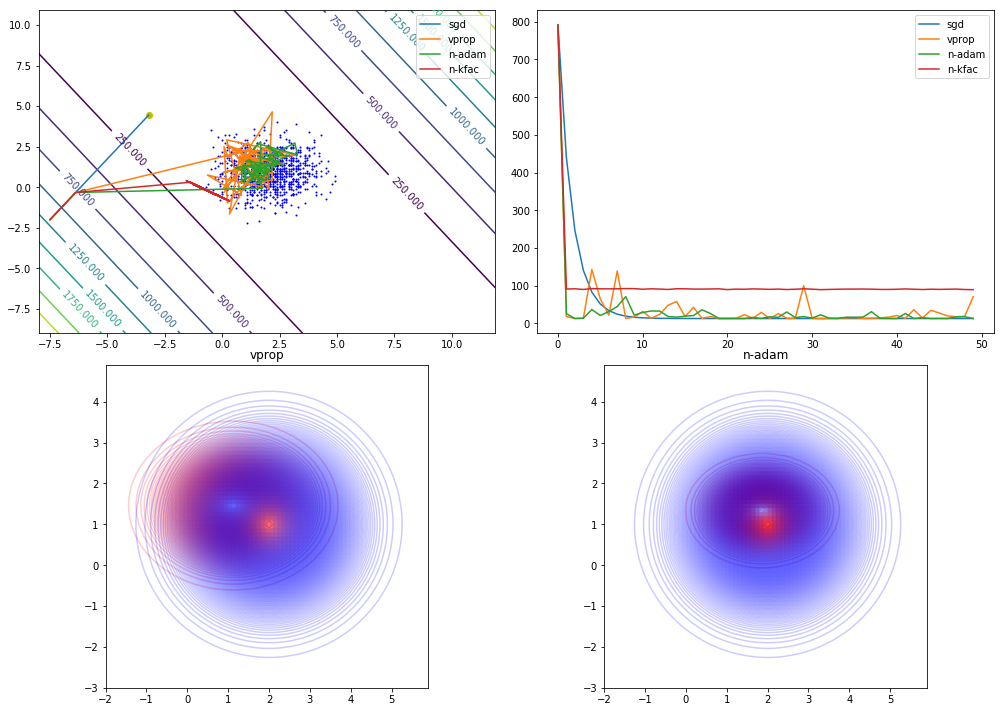

epoch 49, SGD loss   13.013331413269043
epoch 49, Vpp loss   70.7483139038086
epoch 49, Nad loss   13.152542114257812
epoch 49, NKfac loss 89.40391540527344


In [12]:
epochs = 50
losses_sg = []
losses_vp = []
losses_na = []
losses_kfac = []
#losses_lb = []
losses_newton = []

p_w1      = np.zeros(shape=(epochs))
p_w2      = np.zeros(shape=(epochs))
wdict = {}
wdict['sgd_w1']  = [i0[0][0]]
wdict['sgd_w2']  = [i0[0][1]]
wdict['vpp_w1']  = [i0[0][0]]
wdict['vpp_w2']  = [i0[0][1]]
wdict['nad_w1']  = [i0[0][0]]
wdict['nad_w2']  = [i0[0][1]]
wdict['kfac_w1'] = [i0[0][0]]
wdict['kfac_w2'] = [i0[0][1]]
#wdict['lbfgs_w1'] = [i0[0][0]]
#wdict['lbfgs_w2'] = [i0[0][1]]
#wdict['newton_w1'] = [i0[0][0]]
#wdict['newton_w2'] = [i0[0][1]]

plt.figure()
ws = 4                                      
X1 = np.arange(w_mu[0]-ws, w_mu[0]+ws, 0.1)
X2 = np.arange(w_mu[1]-ws, w_mu[1]+ws, 0.1)
X1, X2 = np.meshgrid(X1, X2)
T = mlab.bivariate_normal(X1, X2, sigmax=w_S[0,0], sigmay=w_S[1,1], mux=w_mu[0], muy=w_mu[1], sigmaxy=0.0)


for epoch in range(epochs):

    inputs  = Variable(torch.from_numpy(Xrep))
    targets = Variable(torch.from_numpy(Y))
    

    # sample
    vpp_dist = VPROP.sample(init_point=i0)
    nad_dist = nADAM.sample(init_point=i0)
    nKFAC.sample(init_point=i0)

    
    # forward pass
    #NEWTON.zero_grad()
    SGD.zero_grad()
    #LBFGS.zero_grad()
    VPROP.zero_grad()
    nADAM.zero_grad()
    nKFAC.zero_grad()

    #outputs_nt = Newton_model.forward(inputs)
    outputs_sg = SGD_model.forward(inputs)
    #outputs_lb = LBFGS_model.forward(inputs)
    outputs_vp = Vprop_model.forward(inputs)
    outputs_na = noisyAdam_model.forward(inputs)
    outputs_kc = noisyKFAC_model.forward(inputs)


    # backprop & update
    #loss_nt = criterion(outputs_nt, targets)
    loss_sg = criterion(outputs_sg, targets)
    #loss_lb = criterion(outputs_lb, targets)
    loss_vp = criterion(outputs_vp, targets)
    loss_na = criterion(outputs_na, targets)
    loss_kf = criterion(outputs_kc, targets)

    #loss_nt.backward(retain_graph=True)
    loss_sg.backward()
    #loss_lb.backward()
    loss_vp.backward()
    loss_na.backward()
    loss_kf.backward()

    #NEWTON.step(loss_nt, Newton_model)
    SGD.step()
    #loss_lb = LBFGS.step(closure)
    VPROP.step()
    nADAM.step()
    nKFAC.step()

    
        
    # adapt lr
    #SGD_scheduler.step()

    """______ Plots _____"""

    #for p in list(Newton_model.parameters()):
    #    wdict['newton_w1'] += [p.data[0][0]]
    #    wdict['newton_w2'] += [p.data[0][1]]
    for p in list(SGD_model.parameters()):
        wdict['sgd_w1'] += [p.data[0][0]]
        wdict['sgd_w2'] += [p.data[0][1]]
    #for p in list(LBFGS_model.parameters()):
    #    wdict['lbfgs_w1'] += [p.data[0][0]]
    #    wdict['lbfgs_w2'] += [p.data[0][1]]
    for p in list(Vprop_model.parameters()):
        wdict['vpp_w1'] += [p.data[0][0]]
        wdict['vpp_w2'] += [p.data[0][1]]
    for p in list(noisyAdam_model.parameters()):
        wdict['nad_w1'] += [p.data[0][0]]
        wdict['nad_w2'] += [p.data[0][1]] 
    for p in list(noisyKFAC_model.parameters()):
        wdict['kfac_w1'] += [p.data[0][0]]
        wdict['kfac_w2'] += [p.data[0][1]]


    # collect losses
    #losses_newton.append(loss_nt.data[0])
    losses_sg.append(loss_sg.data[0])
    #losses_lb.append(loss_lb.data[0])
    losses_vp.append(loss_vp.data[0])
    losses_na.append(loss_na.data[0])
    losses_kfac.append(loss_kf.data[0])
    
    
    plot_landscape_and_losses(vpp_dist, nad_dist, w_mu, wdict,  \
                              losses=[ losses_sg, losses_vp, losses_na, losses_kfac, losses_newton], \
                              labels=[ 'sgd', 'vprop', 'n-adam', 'n-kfac',  'newton'], \
                              num_models=4)
    
    print('epoch {}, SGD loss   {}'.format(epoch, loss_sg.data[0]))
    #print('epoch {}, Newton loss{}'.format(epoch, loss_nt.data[0]))
    #print('epoch {}, LBFGS loss {}'.format(epoch, loss_lb.data[0]))
    print('epoch {}, Vpp loss   {}'.format(epoch, loss_vp.data[0]))
    print('epoch {}, Nad loss   {}'.format(epoch, loss_na.data[0]))
    print('epoch {}, NKfac loss {}'.format(epoch, loss_kf.data[0]))


In [13]:
def psis_diagnostic(num_samples, q_samples, q_mu, q_simga, NLL):
    """Algorithm 1 from Aki et al 2018 which uses
       PSIS (Pareto Smooth Importance Sampling) to
       diagnose the quality of the variational 
       approximation to the posterior"""
    
    # Initialize vars
    sample_dim = len(q_mu[0])
    r = np.ndarray((sample_dim, num_samples))
    print(r.shape)
    
    # 1. create q_theta distribution
    q = norm(q_mu, q_sigma) 
    
    # 2. create prior distribution
    prior = norm(0,1)
    
    # 3. compute importance ratios
    for i in range(num_samples):
        r[:,i] = NLL[i] + prior.logpdf(q_samples[:,i]) /  q.logpdf(q_samples[:,i])
        
    # 4. fit pareto
    lw_out, kss = psislw(r)
    
    # 5. report goodness of fit
    print("PSIS K value is: ", kss)
    
    return lw_out, kss
    
def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out

def get_weights2(model):
    w_hat = []
    for p in model.parameters():
        w_hat.extend(p.data.numpy())
    return np.hstack(w_hat) 

In [14]:
dim = 2 #number of model parameters
S = 100 #number of samples
q_samples  = np.ndarray((dim, S))
nll_losses = np.ndarray(S)
for i in range(S):
    inputs  = Variable(torch.from_numpy(Xrep))
    targets = Variable(torch.from_numpy(Y))

    # sample
    params = nADAM.sample()
    q_samples[:,i] = get_weights2(noisyAdam_model)
    
    # forward pass
    outputs_na = noisyAdam_model.forward(inputs)
    
    # compute nll loss
    loss = criterion(outputs_na, targets)
    nll_losses[i] = loss.data[0]
    

# Extracting mu and sigma from dict
q_mu    =[]
q_sigma =[]
for key, value in params.items():
    if "mu" in key:
        q_mu.extend(value.numpy())
    elif "sigma" in key:
        q_sigma.extend(value.numpy())
    else:
        print("Parameter ", key, "was not stored")

# Running Diagnostic
_, _ = psis_diagnostic(num_samples=S, q_samples=q_samples, q_mu=q_mu, q_simga=q_sigma, NLL=nll_losses) 

(2, 100)
PSIS K value is:  [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf]
